## Import libraries

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import gfacts
from gfacts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from gfacts.models import customLogisticRegression
from gfacts.parameters import ParameterProxy
from gfacts.formatting import recourse_report_reverse, print_recourse_report

import matplotlib.pyplot as plt

In [2]:
DATAFILE = '../ad_campaign_data.csv' # location of dataset
random_state = None # change to something for exactly reproducible results

# as selected in "tutorial_bias_advertising" notebook
selected_features = ['gender', 'parents', 'age', 'income', 'area', 'college_educated', 'homeowner']
cate_features = ['gender', 'parents', 'age', 'income', 'area', 'college_educated']
num_features = ['homeowner']

# if not specified, set to 1
feature_weights = {"gender": 1, "parents": 1, "age": 1}

target_name = "true_conversion"
positive_label = 1
negative_label = 0

model_train_fraction = 0.7
learning_class_weights = {0: 0.5, 1: 265}

sensitive_attribute = "gender"
sensitive_alias = {"M": "Male", "F": "Female", "Unknown": "Unknown"}

## Load Dataset

In [3]:
ad_conversion_dataset = pd.read_csv(DATAFILE)
ad_conversion_dataset.head()

,religion,politics,college_educated,parents,homeowner,gender,age,income,area,true_conversion,predicted_conversion,predicted_probability
0,Unknown,Unknown,1,1,1,Unknown,55-64,Unknown,Unknown,0,0,0.001351
1,Other,Unknown,1,1,1,Unknown,55-64,Unknown,Urban,0,0,0.002238
2,Unknown,Unknown,1,1,1,F,55-64,Unknown,Unknown,0,0,0.002704
3,Unknown,Unknown,1,1,1,F,55-64,Unknown,Unknown,0,0,0.001967
4,Unknown,Unknown,1,1,1,F,55-64,Unknown,Urban,0,0,0.001681


In [4]:
ad_conversion_dataset.gender = ad_conversion_dataset.gender.map(sensitive_alias)

### Print some statistics for the dataset

In [8]:
print(f"Number of (instances, attributes) in the dataset = {ad_conversion_dataset.shape}")
print()

print(f"Statistics of true conversions (0=no, 1=yes)")
print(ad_conversion_dataset.true_conversion.value_counts())
print()

print(f"Statistics of predicted conversions (0=no, 1=yes)")
print(ad_conversion_dataset.predicted_conversion.value_counts())

Number of (instances, attributes) in the dataset = (1443140, 12)

Statistics of true conversions (0=no, 1=yes)
0    1440766
1       2374
Name: true_conversion, dtype: int64

Statistics of predicted conversions (0=no, 1=yes)
0    1440773
1       2367
Name: predicted_conversion, dtype: int64


### Warning!

There is no model!

Predictions (from whatever model has been used) have been incorporated into the dataset, in the columns "predicted_conversion" (which is the predicted label) and "predicted_probability" (which is the predicted probability of belonging to the positive class).

Moreover, the dataset is highly unbalanced, and this is also evident in the poor efficiency of the model, as demonstrated in the confusion matrix below.

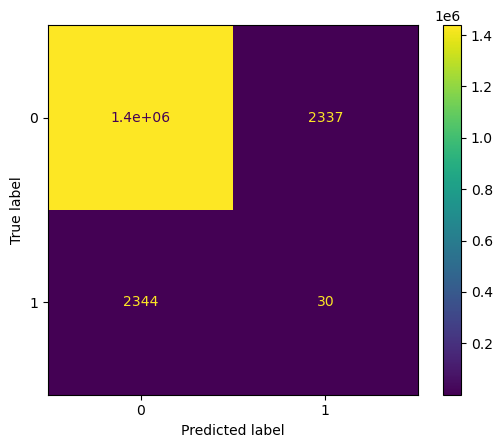

In [9]:
conf_matrix = confusion_matrix(ad_conversion_dataset.true_conversion, ad_conversion_dataset.predicted_conversion)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

# Preprocessing

In [10]:
## keep only the columns in selected_features, plus the label column
ad_conversion_dataset = ad_conversion_dataset[selected_features + [target_name]]
ad_conversion_dataset

,gender,parents,age,income,area,college_educated,homeowner,true_conversion
0,Unknown,1,55-64,Unknown,Unknown,1,1,0
1,Unknown,1,55-64,Unknown,Urban,1,1,0
2,Female,1,55-64,Unknown,Unknown,1,1,0
3,Female,1,55-64,Unknown,Unknown,1,1,0
4,Female,1,55-64,Unknown,Urban,1,1,0
...,...,...,...,...,...,...,...,...
1443135,Female,1,25-34,Unknown,Unknown,1,1,0
1443136,Female,1,55-64,Unknown,Unknown,1,0,0
1443137,Unknown,1,55-64,Unknown,Unknown,1,1,0
1443138,Female,1,55-64,Unknown,Unknown,1,1,0


In [11]:
## train-test split

X = ad_conversion_dataset.drop(target_name, axis=1)
y = ad_conversion_dataset[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=model_train_fraction, random_state=random_state, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Model training

In [12]:
%%time

model = customLogisticRegression(class_weight=learning_class_weights)
model.fit(X_train, y_train, cate_columns=cate_features, target_column=target_name)
model.predict(X_test.iloc[:100, :])

CPU times: total: 3.27 s
Wall time: 7.01 s


array([0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

# Testing the model

We check if the model is satisfactory.

In [13]:
preds = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94    432231
           1       0.00      0.12      0.00       712

    accuracy                           0.89    432943
   macro avg       0.50      0.50      0.47    432943
weighted avg       1.00      0.89      0.94    432943



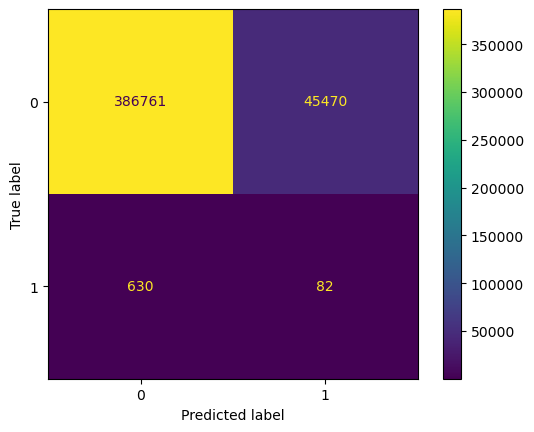

In [14]:
conf_matrix = confusion_matrix(y_test, preds)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

Given the high imbalance of the dataset, we consider that the above results, for a simple logistic regression, are good enough.

# Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [15]:
ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
    X_test,
    model,
    sensitive_attribute,
    missing_subgroup_val="Unknown"
)

print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

100%|██████████| 364/364 [00:54<00:00,  6.63it/s]

Number of if-thens: 364


Uncomment the following block if you wish to load rules object from disk.

In [16]:
# import dill

# with open("rules.data", "rb") as inf:
#     rules_by_if = dill.load(inf)

In [17]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1]["Male"][1][0][1]-e[1]["Female"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If age = 55-64, area = Unknown, homeowner = 1, income = Unknown:
	Subgroup 'Female', 61.7190% covered
		Make homeowner = 0, income = <100K with correctness -0.0000%.
	Subgroup 'Male', 62.5975% covered
		Make homeowner = 0, income = <100K with correctness 89.2881%.
If age = 55-64, area = Urban, homeowner = 1, income = Unknown:
	Subgroup 'Female', 22.1702% covered
		Make area = Unknown, homeowner = 0, income = <100K with correctness 0.0000%.
	Subgroup 'Male', 22.3580% covered
		Make area = Unknown, homeowner = 0, income = <100K with correctness 89.2688%.
If age = 25-34, area = Unknown, homeowner = 1, income = Unknown:
	Subgroup 'Female', 1.1758% covered
		Make age = 55-64, homeowner = 0, income = <100K with correctness 0.0000%.
	Subgroup 'Male', 1.2628% covered
		Make age = 55-64, homeowner = 0, income = <100K with correctness 88.5741%.
If area = Unknown, homeowner = 1, income = >100K:
	Subgroup 'Female', 1.0251% covered
		Make homeowner = 0, income = <100K with correctness 0.0000%.
	Sub

In [18]:
# #### Uncomment if you wish to save rules object on disk

# import dill

# with open("rules.data", "wb") as outf:
#     dill.dump(rules_by_if, outf)

# Filter rules by different fairness definitions

Here, we explore more sophisticated ways of picking the "top" K rules and showing only those.

We start ranking the rule "groups" (all recourses for a single "if") by averaging out the costs of all suggested recourses, weighted by the respective correctness. For now, the "cost" of a recourse is simply the number of features whose value changes (and the magnitude of the change for numerical features, but here there are none).

In [19]:
comparators = gfacts.naive_feature_change_builder(num_cols=num_features, cate_cols=cate_features, feature_weights=feature_weights)
params = ParameterProxy(featureChanges=comparators)

## Weighted Average Score

In [20]:
top_rules = gfacts.select_rules_subset(
    rules_by_if,
    metric = "weighted-average",
    sort_strategy = "abs-diff-decr",
    top_count = 10
)

pop_sizes = {sg: (ad_conversion_dataset["gender"] == sg).sum() for sg in ad_conversion_dataset["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=gfacts.calculate_all_if_subgroup_costs(list(top_rules.keys()), list(top_rules.values()))
))

If age = 55-64, area = Urban, homeowner = 1, income = Unknown:
	Subgroup 'Female', 22.1702% covered out of 600135
		Make area = Unknown, homeowner = 0, income = <100K with correctness 0.0000%.
		Aggregate cost of the above recourses = 0.0
	Subgroup 'Male', 22.3580% covered out of 314181
		Make area = Unknown, homeowner = 0, income = <100K with correctness 89.2688%.
		Aggregate cost of the above recourses = 2.67806
If age = 25-34, area = Unknown, homeowner = 1, income = Unknown:
	Subgroup 'Female', 1.1758% covered out of 600135
		Make age = 55-64, homeowner = 0, income = <100K with correctness 0.0000%.
		Aggregate cost of the above recourses = 3.33067e-16
	Subgroup 'Male', 1.2628% covered out of 314181
		Make age = 55-64, homeowner = 0, income = <100K with correctness 88.5741%.
		Aggregate cost of the above recourses = 2.65722
If area = Urban, homeowner = 1, income = Unknown:
	Subgroup 'Female', 23.7036% covered out of 600135
		Make area = Unknown, homeowner = 0, income = <100K with cor

## Minimum cost above threshold

In [25]:
top_rules = gfacts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    # filter_sequence=["remove-below-thr"]
)

pop_sizes = {sg: (ad_conversion_dataset["gender"] == sg).sum() for sg in ad_conversion_dataset["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=gfacts.calculate_all_if_subgroup_costs(
        list(top_rules.keys()),
        list(top_rules.values()),
        group_calculator=gfacts.if_group_cost_min_change_correctness_threshold,
        cor_thres=0.5
    )
))

If parents = 1, homeowner = 1, income = Unknown:
	Subgroup 'Female', 89.5084% covered out of 600135
		Make homeowner = 0, income = <100K with correctness 28.9437%.
		Make income = >100K with correctness 22.0602%.
		Aggregate cost of the above recourses = inf
	Subgroup 'Male', 90.8023% covered out of 314181
		Make homeowner = 0, income = <100K with correctness 90.3487%.
		Make income = >100K with correctness 28.3840%.
		Aggregate cost of the above recourses = 2.0
If age = 55-64, parents = 1, homeowner = 1, income = Unknown:
	Subgroup 'Female', 83.7410% covered out of 600135
		Make homeowner = 0, income = <100K with correctness 30.3774%.
		Make income = >100K with correctness 23.5795%.
		Aggregate cost of the above recourses = inf
	Subgroup 'Male', 84.8983% covered out of 314181
		Make homeowner = 0, income = <100K with correctness 95.9926%.
		Make income = >100K with correctness 29.8593%.
		Aggregate cost of the above recourses = 2.0
If area = Unknown, homeowner = 1, income = Unknown:
	

## Cost above threshold

In [22]:
top_rules = gfacts.select_rules_subset(
    rules_by_if,
    metric="total-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr"]
)

pop_sizes = {sg: (ad_conversion_dataset["gender"] == sg).sum() for sg in ad_conversion_dataset["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=gfacts.calculate_all_if_subgroup_costs(
        list(top_rules.keys()),
        list(top_rules.values()),
        group_calculator=gfacts.if_group_cost_sum_change_correctness_threshold,
        cor_thres=0.5
    )
))

If parents = 1, homeowner = 1, income = Unknown:
	Subgroup 'Female', 89.5084% covered out of 600135
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'Male', 90.8023% covered out of 314181
		Make homeowner = 0, income = <100K with correctness 90.3487%.
		Aggregate cost of the above recourses = 2.0
If age = 55-64, parents = 1, homeowner = 1, income = Unknown:
	Subgroup 'Female', 83.7410% covered out of 600135
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'Male', 84.8983% covered out of 314181
		Make homeowner = 0, income = <100K with correctness 95.9926%.
		Aggregate cost of the above recourses = 2.0
If area = Unknown, homeowner = 1, income = Unknown:
	Subgroup 'Female', 65.9845% covered out of 600135
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'Male', 66.9024% covered out of 314181
		Make homeowner = 0, income = <100K with correctness 83.5428%.
		Aggregate c

## Number above threshold

In [7]:
top_rules = gfacts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr"]
)

pop_sizes = {sg: (ad_conversion_dataset["gender"] == sg).sum() for sg in ad_conversion_dataset["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=gfacts.calculate_all_if_subgroup_costs(
        list(top_rules.keys()),
        list(top_rules.values()),
        group_calculator=gfacts.if_group_cost_recoursescount_correctness_threshold,
        cor_thres=0.5
    )
))

If homeowner = 1, income = Unknown:
	Subgroup 'Female', 94.7100% covered out of 600135
		Make homeowner = 0 with correctness 92.0515%.
		Make homeowner = 0, income = >100K with correctness 96.6250%.
		Aggregate cost of the above recourses = 2.0
	Subgroup 'Male', 95.8942% covered out of 314181
		Make homeowner = 0 with correctness 92.3982%.
		Make homeowner = 0, income = >100K with correctness 97.0851%.
		Make homeowner = 0, income = <100K with correctness 85.5512%.
		Aggregate cost of the above recourses = 3.0
If parents = 1, homeowner = 1, income = Unknown:
	Subgroup 'Female', 89.5084% covered out of 600135
		No recourses for this subgroup!
		Aggregate cost of the above recourses = 0.0
	Subgroup 'Male', 90.8023% covered out of 314181
		Make homeowner = 0, income = <100K with correctness 90.3487%.
		Aggregate cost of the above recourses = 1.0
If age = 55-64, homeowner = 1, income = Unknown:
	Subgroup 'Female', 88.6012% covered out of 600135
		Make homeowner = 0 with correctness 96.1274

# Experimentation with cumulative correctness plots for each rule

First, load state from disk, if you wish.

In [5]:
# import dill

# with open("state.data", "rb") as inf:
#     rules_by_if, model, X_test = dill.load(inf)

If parents = 1, homeowner = 1, income = Unknown:
	Subgroup 'Female', 89.5084% covered out of 600135
		Make homeowner = 0, income = <100K with correctness 28.9437%.
		Make income = >100K with correctness 22.0602%.
		Aggregate cost of the above recourses = 0.0
	Subgroup 'Male', 90.8023% covered out of 314181
		Make homeowner = 0, income = <100K with correctness 90.3487%.
		Make income = >100K with correctness 28.3840%.
		Aggregate cost of the above recourses = 1.0
	Cumulative correctness plot for the above recourses.


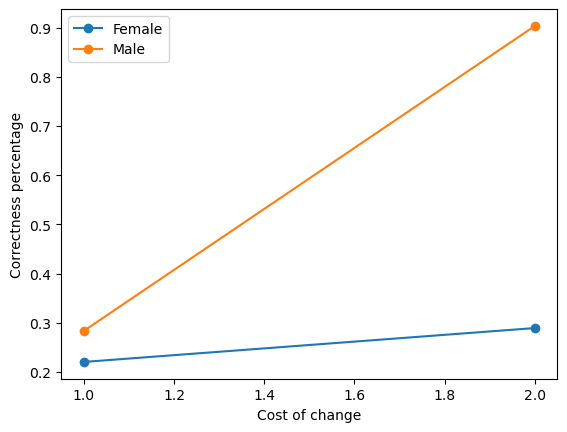

If age = 55-64, parents = 1, homeowner = 1, income = Unknown:
	Subgroup 'Female', 83.7410% covered out of 600135
		Make homeowner = 0, income = <100K with correctness 30.3774%.
		Make income = >100K with correctness 23.5795%.
		Aggregate cost of the above recourses = 0.0
	Subgroup 'Male', 84.8983% covered out of 314181
		Make homeowner = 0, income = <100K with correctness 95.9926%.
		Make income = >100K with correctness 29.8593%.
		Aggregate cost of the above recourses = 1.0
	Cumulative correctness plot for the above recourses.


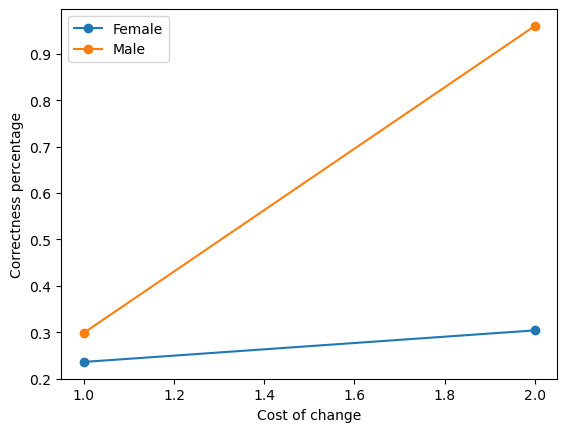

If area = Unknown, homeowner = 1, income = Unknown:
	Subgroup 'Female', 65.9845% covered out of 600135
		Make homeowner = 0, income = <100K with correctness 0.0000%.
		Aggregate cost of the above recourses = 0.0
	Subgroup 'Male', 66.9024% covered out of 314181
		Make homeowner = 0, income = <100K with correctness 83.5428%.
		Aggregate cost of the above recourses = 1.0
	Cumulative correctness plot for the above recourses.


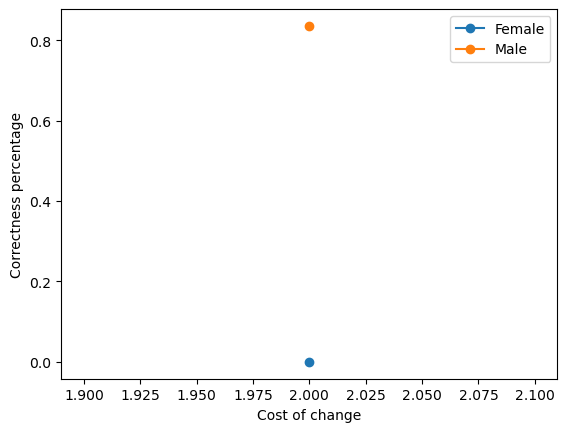

If age = 55-64, area = Unknown, homeowner = 1, income = Unknown:
	Subgroup 'Female', 61.7190% covered out of 600135
		Make homeowner = 0, income = <100K with correctness -0.0000%.
		Aggregate cost of the above recourses = 0.0
	Subgroup 'Male', 62.5975% covered out of 314181
		Make homeowner = 0, income = <100K with correctness 89.2881%.
		Aggregate cost of the above recourses = 1.0
	Cumulative correctness plot for the above recourses.


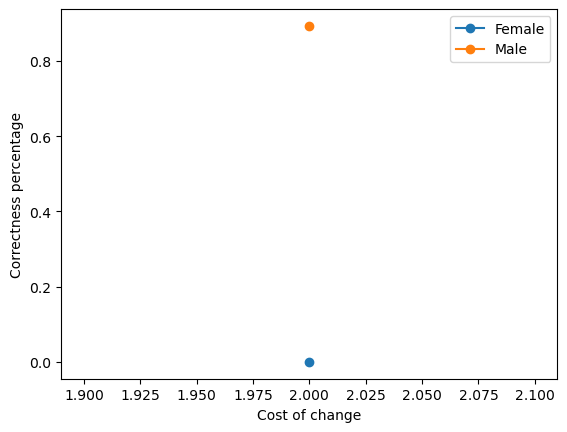

If area = Urban, homeowner = 1, income = Unknown:
	Subgroup 'Female', 23.7036% covered out of 600135
		Make area = Unknown, homeowner = 0, income = <100K with correctness 0.0000%.
		Aggregate cost of the above recourses = 0.0
	Subgroup 'Male', 23.9202% covered out of 314181
		Make area = Unknown, homeowner = 0, income = <100K with correctness 83.4389%.
		Aggregate cost of the above recourses = 1.0
	Cumulative correctness plot for the above recourses.


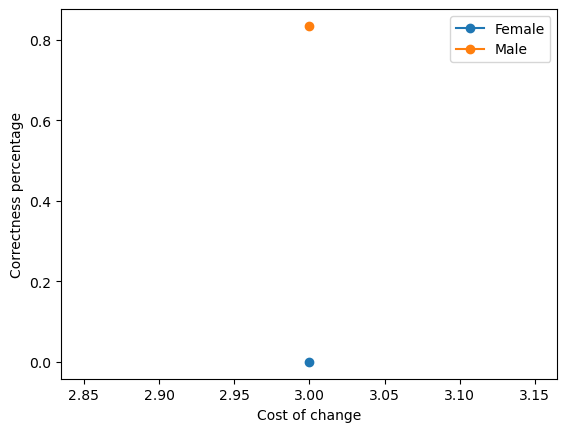

If age = 55-64, area = Urban, homeowner = 1, income = Unknown:
	Subgroup 'Female', 22.1702% covered out of 600135
		Make area = Unknown, homeowner = 0, income = <100K with correctness 0.0000%.
		Aggregate cost of the above recourses = 0.0
	Subgroup 'Male', 22.3580% covered out of 314181
		Make area = Unknown, homeowner = 0, income = <100K with correctness 89.2688%.
		Aggregate cost of the above recourses = 1.0
	Cumulative correctness plot for the above recourses.


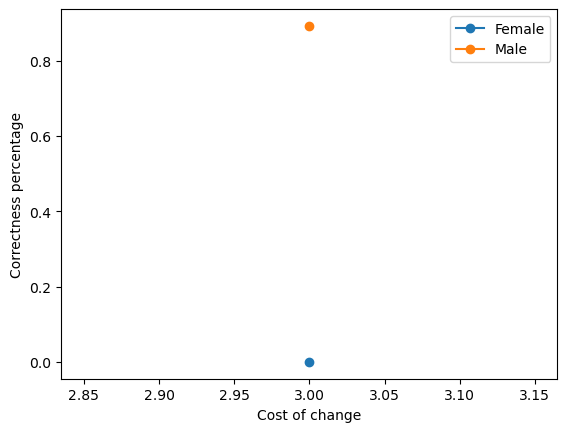

If parents = 0, homeowner = 1, income = Unknown:
	Subgroup 'Female', 5.2017% covered out of 600135
		Make parents = 1, homeowner = 0, income = <100K with correctness 28.3747%.
		Make parents = 1, income = >100K with correctness 21.6431%.
		Aggregate cost of the above recourses = 0.0
	Subgroup 'Male', 5.0919% covered out of 314181
		Make parents = 1, homeowner = 0, income = <100K with correctness 89.9297%.
		Make parents = 1, income = >100K with correctness 28.3138%.
		Aggregate cost of the above recourses = 1.0
	Cumulative correctness plot for the above recourses.


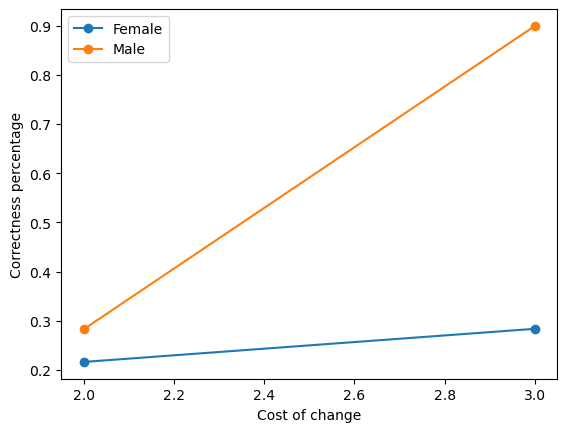

If age = 55-64, parents = 0, homeowner = 1, income = Unknown:
	Subgroup 'Female', 4.8602% covered out of 600135
		Make parents = 1, homeowner = 0, income = <100K with correctness 29.7078%.
		Make parents = 1, income = >100K with correctness 23.1639%.
		Aggregate cost of the above recourses = 0.0
	Subgroup 'Male', 4.7390% covered out of 314181
		Make parents = 1, homeowner = 0, income = <100K with correctness 95.9235%.
		Make parents = 1, income = >100K with correctness 29.8943%.
		Aggregate cost of the above recourses = 1.0
	Cumulative correctness plot for the above recourses.


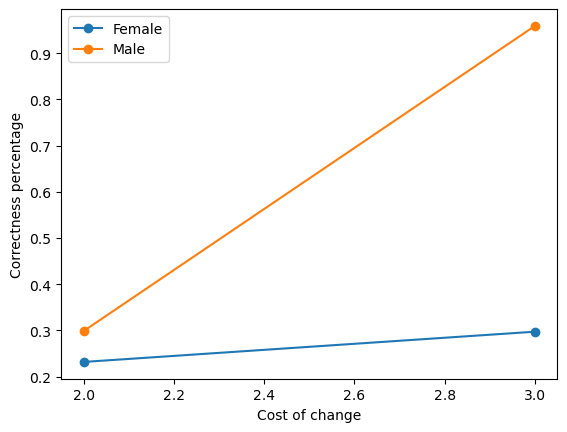

If age = 55-64, income = <100K:
	Subgroup 'Female', 2.8716% covered out of 600135
		Make income = Unknown with correctness 43.6344%.
		Make income = >100K with correctness 50.4086%.
		Make age = 25-34, income = Unknown with correctness 40.7097%.
		Aggregate cost of the above recourses = 1.0
	Subgroup 'Male', 1.7542% covered out of 314181
		Make income = Unknown with correctness 5.5065%.
		Make income = >100K with correctness 20.2583%.
		Make age = 25-34, income = Unknown with correctness 5.5065%.
		Aggregate cost of the above recourses = 0.0
	Cumulative correctness plot for the above recourses.


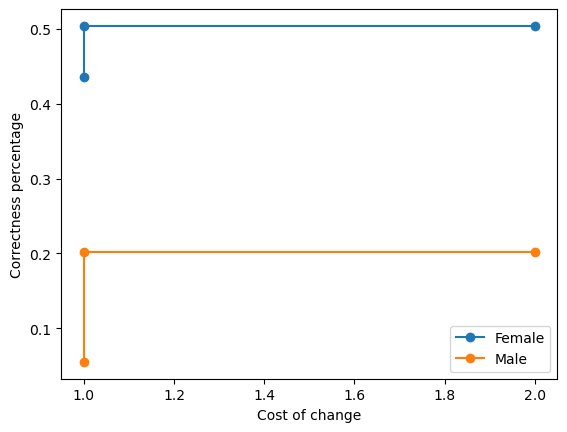

If age = 55-64, parents = 1, income = <100K:
	Subgroup 'Female', 2.7012% covered out of 600135
		Make income = Unknown with correctness 46.3420%.
		Make income = >100K with correctness 50.9145%.
		Make age = 25-34, income = Unknown with correctness 43.2327%.
		Aggregate cost of the above recourses = 1.0
	Subgroup 'Male', 1.5812% covered out of 314181
		Make income = Unknown with correctness 5.8824%.
		Make income = >100K with correctness 17.3454%.
		Make age = 25-34, income = Unknown with correctness 5.8824%.
		Aggregate cost of the above recourses = 0.0
	Cumulative correctness plot for the above recourses.


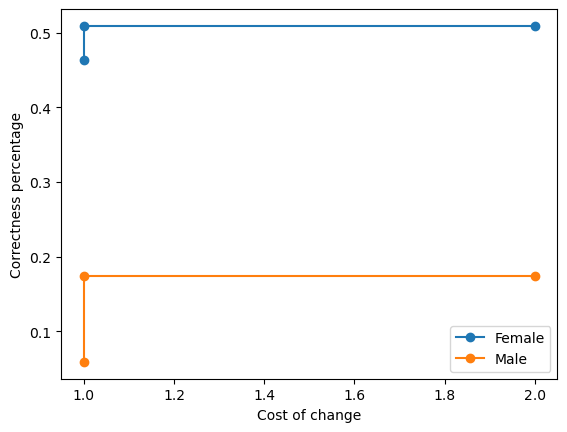

In [8]:
top_rules = gfacts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    # filter_sequence=["remove-below-thr"]
)

cum_cors = gfacts.cumcorr_all(top_rules, X_test, model, sensitive_attribute=sensitive_attribute)

pop_sizes = {sg: (ad_conversion_dataset["gender"] == sg).sum() for sg in ad_conversion_dataset["gender"].unique()}
print_recourse_report(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=gfacts.calculate_all_if_subgroup_costs(
        list(top_rules.keys()),
        list(top_rules.values()),
        group_calculator=gfacts.if_group_cost_recoursescount_correctness_threshold,
        cor_thres=0.5
    ),
    aggregate_cors_costs=cum_cors
)

Finally, save state, if you wish.

In [ ]:
# import dill

# with open("state.data", "wb") as outf:
#     dill.dump((rules_by_if, model, X_test), outf)